In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, concatenate
from keras.layers import GaussianDropout, GaussianNoise
from keras.layers import GRU, Bidirectional, TimeDistributed
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import os
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

import fasttext

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
# DATASET
DATASET_COLUMNS = ["target", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S"

# WORD2VEC
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 6
W2V_SIZE = 200

SEQUENCE_LENGTH = 200

MAXLEN = 100
MAX_SENTENCES = 15
MAX_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

# class defining the custom attention layer
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim=100, **kwargs):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]
    
    def get_config(self):
        config = {'supports_masking': self.supports_masking, 'attention_dim': self.attention_dim}
        base_config = super(HierarchicalAttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
df_train = pd.read_csv("yelp2015/train.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df_test = pd.read_csv("yelp2015/test.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [4]:
def preprocess(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
      tokens.append(token)
    return " ".join(tokens)

In [6]:
%%time
df_train.text = df_train.text.apply(lambda x: preprocess(x))
df_test.text = df_test.text.apply(lambda x: preprocess(x))

Wall time: 19.3 s


In [7]:
decode_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))

Wall time: 394 ms


In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\covin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
from nltk import tokenize

reviews = []
labels = []
texts = []

for idx, _ in df_train.iterrows():
    text = df_train.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_train.target[idx])

TRAIN_SIZE = len(texts)

for idx, _ in df_test.iterrows():
    text = df_test.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_test.target[idx])

In [11]:
from keras.preprocessing.text import text_to_word_sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTENCES:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 274081 unique tokens.


In [12]:
from keras.utils.np_utils import to_categorical

labels = to_categorical(np.asarray(labels))
print('Shape of reviews (data) tensor:', data.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

Shape of reviews (data) tensor: (700000, 15, 100)
Shape of sentiment (label) tensor: (700000, 5)


In [13]:
x_train = data[:TRAIN_SIZE]
y_train = labels[:TRAIN_SIZE]
x_test = data[TRAIN_SIZE:]
y_test = labels[TRAIN_SIZE:]

In [14]:
ft = fasttext.load_model("cc.en.100.bin")

In [15]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
  if word in ft:
    embedding_matrix[i] = ft[word]

embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAXLEN, trainable=True)

In [16]:
sentence_input = Input(shape=(MAXLEN,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
attn_word = HierarchicalAttentionNetwork(100)(lstm_word)
sentenceEncoder = Model(sentence_input, attn_word)

review_input = Input(shape=(MAX_SENTENCES, MAXLEN), dtype='int32')
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(50, return_sequences=True))(review_encoder)
attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
preds = Dense(5, activation='softmax')(attn_sentence)
model = Model(review_input, preds)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-04-30 12:48:14,629 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


tracking <tf.Variable 'hierarchical_attention_network_1/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_1/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_1/Variable_2:0' shape=(100, 1) dtype=float32> u
tracking <tf.Variable 'hierarchical_attention_network_2/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_2/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_2/Variable_2:0' shape=(100, 1) dtype=float32> u


In [17]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100)           27463700  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 100)           45300     
_________________________________________________________________
hierarchical_attention_netwo (None, 100)               10200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 27,519,705
Trainable params: 27,519,705
Non-trainable params: 0
_________________________________________________________________


In [18]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, mode='max')]

In [19]:
print("model fitting - Hierachical attention network")
history = model.fit(x_train, y_train, validation_split=0.2, nb_epoch=10, batch_size=64, callbacks=callbacks)

model fitting - Hierachical attention network


C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


2020-04-30 12:48:23,665 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 520000 samples, validate on 130000 samples
Epoch 1/10
520000/520000 [==============================] - 3295s 6ms/step - loss: 1.2723 - acc: 0.4158 - val_loss: 0.9187 - val_acc: 0.5980
Epoch 2/10
520000/520000 [==============================] - 3333s 6ms/step - loss: 0.9183 - acc: 0.5956 - val_loss: 0.8460 - val_acc: 0.6325
Epoch 3/10
520000/520000 [==============================] - 3354s 6ms/step - loss: 0.8732 - acc: 0.6163 - val_loss: 0.8187 - val_acc: 0.6438
Epoch 4/10
520000/520000 [==============================] - 3394s 7ms/step - loss: 0.8479 - acc: 0.6275 - val_loss: 0.7917 - val_acc: 0.6583
Epoch 5/10
520000/520000 [==============================] - 3421s 7ms/step - loss: 0.8317 - acc: 0.6345 - val_loss: 0.7770 - val_acc: 0.6649
Epoch 6/10
520000/520000 [==============================] - 3508s 7ms/step - loss: 0.8180 - acc: 0.6407 - val_loss: 0.7841 - val_acc: 0.6588
Epoch 7/10
520000/520000 [==============================] - 3530s 7ms/step - loss: 0.8061 - acc: 0.646

In [20]:
%%time
score = model.evaluate(x_test, y_test, batch_size=100)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

50000/50000 [==============================] - 96s 2ms/step

ACCURACY: 0.6394000053405762
LOSS: 0.8222057861089707
Wall time: 1min 35s


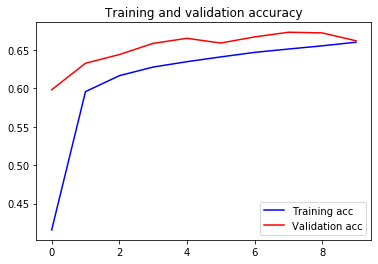

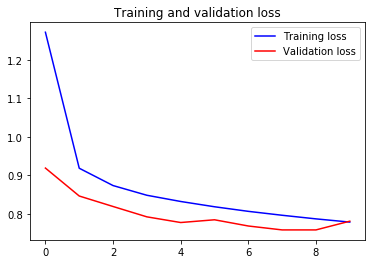

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [22]:
model.save("hatn_yelp_fasttext_modregex.h5")
pickle.dump(tokenizer, open("tokenizer_fasttext_modregex.pkl", "wb"), protocol=0)

In [6]:
from keras.models import load_model

model = load_model("hatn_yelp_fasttext_modregex.h5", custom_objects={'HierarchicalAttentionNetwork':HierarchicalAttentionNetwork})
tokenizer = None
with open('tokenizer_fasttext_modregex.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

tracking <tf.Variable 'hierarchical_attention_network_1_1/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_1_1/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_1_1/Variable_2:0' shape=(100, 1) dtype=float32> u
tracking <tf.Variable 'hierarchical_attention_network_2_1/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_2_1/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_2_1/Variable_2:0' shape=(100, 1) dtype=float32> u


In [7]:
from nltk import tokenize
from keras.preprocessing.text import text_to_word_sequence

def predict_new_text(text, model, tokenizer):
    text = preprocess(text)
    texts = []
    reviews = []
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)

    data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

    for i, sentences in enumerate(reviews):
        for j, sent in enumerate(sentences):
            if j < MAX_SENTENCES:
                wordTokens = text_to_word_sequence(sent)
                k = 0
                for _, word in enumerate(wordTokens):
                    if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1
                        
    ynew = model.predict(data)
    return ynew

In [8]:
text = "the restaurant we went yesterday was wonderful."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.03428601 0.02652517 0.07617928 0.2560661  0.6069434 ]]
5


In [9]:
text = "the restaurant we went yesterday was awful. The food was bad, the service was bad. Horrible place, disgusting food."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[9.8124725e-01 1.8329209e-02 4.1950576e-04 3.3114686e-06 6.6766455e-07]]
1


In [10]:
text = "The movie was good, funny and entertaining. Good cast and plot."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.0008726  0.02307593 0.5664373  0.38051757 0.02909658]]
3


In [11]:
text = "The movie was bad, boring and too slow paced. Bad cast and plot."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[2.5013918e-01 6.0702753e-01 1.3928321e-01 3.2650847e-03 2.8506454e-04]]
2
